# Building Image Captioning in PyTorch

The goal of image captioning is to describe a given image using natural language. Using neural networks, we can partition the problem into two separate challenges. First, we need to extract meaningful features regarding the image that would help us describe it. Second, we need to generate a sequence of words that best fit those features. Luckily, the flexibility of neural networks allows us to take a CNN architecture and connect it directly to a LSTM network with an appropriate attention mechanism to appropriately weight the feature maps.

1. Read about and download the Flickr8k dataset from <a href="https://www.kaggle.com/adityajn105/flickr8k/activity">here</a> .

1. Create a preprocessing pipeline by creating a custom Pytorch  <a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">dataset</a>. Note that the data contains both images and caption annotation, so you will need to encode the text and map each character to an integer\One-hot vector (Remember to add start of sentence and end of sentence tokens) and apply torchvision.transforms to normalize the images as was done in previous homeworks.

1. Define the feature extractor. This model should take in an image and perform feature extraction on it. You can use a pretrained network such as ResNet (remember to normalize the input image) for this task or create your own Network.

1. Implement an attention mechanism as was described in class that will weight the feature maps for the RNN model.

1. Feed the feature maps that were weighted by the attention mechanism into the LSTM\GRU\RNN decoder that will generate the actual captions.

1. Train your model. Training a proper model might take a while, so you are encouraged to use [Colab](https://colab.research.google.com/).

6. Create function that takes the learned network and predicts a single word. This function should take a hidden state and an input character, and output the next hidden state and the predicted word.
7. Finally, create a sampling function that takes the network, the maximum length of text and produces a caption.


Here is a list of refrences i've used during the process:

https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/

https://www.udemy.com/course/advanced-computer-vision/

https://www.udemy.com/course/the-complete-neural-networks-bootcamp-theory-applications/

https://www.kaggle.com/adityajn105/flickr8k/code

Class presentations 10

##**Imports**

In [52]:
import os
import nltk
import string
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import cv2

import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torchvision import transforms
import torchvision.models as models
from torch.nn.functional import softmax
import torchvision.transforms.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is: {device}')

device is: cuda


##**Dataset**

In [54]:
class CaptionDataset(Dataset):
    def __init__(self, annotations_file: str, images_dir: str, transform, max_seq_length: int = 20):
      self.max_seq_length = max_seq_length
      df = pd.read_csv(annotations_file)
      df['caption'] = df['caption'].apply(self.clean_caption)
      self.df = df
      self.captions_column = self.df['caption']
      self.image_name_column = self.df['image']
      self.df['length'] = self.captions_column.apply(lambda x: len(x.split()))
      self.length_column = self.df['length']
      self.images_dir = images_dir
      self.transform = transform
      words = self.get_unique_words(self.captions_column)
      words.add('<start>')
      words.add('<end>')
      words.add('<PAD>')
      self.word_to_idx_mapping = dict([(word, idx) for idx, word in enumerate(words)])
      self.idx_to_word_mapping = dict([(idx, word) for idx, word in enumerate(words)])
      self.vocab_size = len(words)

    def pad_caption(self, seq):
      padded = np.ones((self.max_seq_length,), dtype=np.int64) * self.word_to_idx_mapping['<PAD>']

      if len(seq) > self.max_seq_length:
          padded[:] = seq[:self.max_seq_length]
      else:
          padded[:len(seq)] = seq

      return padded

    def clean_caption(self, caption):
      caption = [c for c in caption if c not in string.punctuation]
      caption = ''.join(caption)
      caption = caption.split(' ')
      caption = [word.lower() for word in caption if len(word) > 1 and word.isalpha()]
      caption = ' '.join(caption)
      return caption

    def get_unique_words(self, captions):
      words = set()

      for caption in captions:
          words.update(caption.split())

      return words


    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):
      image_name = os.path.join(self.images_dir, self.image_name_column[idx])
      image = Image.open(image_name).convert('RGB')
      caption = self.captions_column[idx]
      tokens = word_tokenize(caption)
      caption = []
      caption.append('<start>')
      caption.extend([token for token in tokens])
      caption.append('<end>')
      caption = [self.word_to_idx_mapping[i] for i in caption]
      caption = self.pad_caption(caption)
      sample = {'image': image, 'caption': caption}
      sample = self.transform(sample)
      return sample

##**Preprocessing**

In [64]:
class ToTensor(object):
    def __call__(self, sample):
        pic = sample['image']
        sample['image'] = F.to_tensor(pic)
        return sample

    def __repr__(self):
        return self.__class__.__name__ + '()'


class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['caption']
        h, w = image.size[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = F.resize(image, (new_h, new_w))
        return {'image': img, 'caption': label}


class Normalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.std = std
        self.inplace = inplace

    def __call__(self, sample):
        img = sample['image']
        sample['image'] = F.normalize(img, self.mean, self.std)
        return sample

##**Encoder**

In [55]:
class Encoder(nn.Module):
    def __init__(self):
      super().__init__()
      resnet = models.resnet101(pretrained=True)
      modules = list(resnet.children())[:-2]
      self.resnet = nn.Sequential(*modules)
      self.fine_tune()

    def forward(self, images):
        encoded_image = self.resnet(images)
        out = encoded_image.permute(0, 2, 3, 1)
        out = out.view(out.size(0), -1, out.size(-1))
        return out

    def fine_tune(self, fine_tune=True):
      for p in self.resnet.parameters():
          p.requires_grad = False

##**Attention**

In [56]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.attention_dim = attention_dim
        self.w = nn.Linear(decoder_dim, attention_dim)
        self.u = nn.Linear(encoder_dim, attention_dim)
        self.a = nn.Linear(attention_dim, 1)

    def forward(self, features, hidden_state):
        u_hs = self.u(features)
        w_ah = self.w(hidden_state)
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))
        attention_scores = self.a(combined_states)
        attention_scores = attention_scores.squeeze(2)
        alpha = softmax(attention_scores, dim=1)
        attention_weights = features * alpha.unsqueeze(2)
        attention_weights = attention_weights.sum(dim=1)
        return alpha, attention_weights

##**Decoder**

In [57]:
class Decoder(nn.Module):
    def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super().__init__()
        self.embed_size = embed_size
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention_dim = attention_dim

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        self.lstm = nn.LSTMCell(embed_size + encoder_dim, decoder_dim)
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.drop = nn.Dropout(drop_prob)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        h, c = self.init_hidden_state(features)
        seq_length = len(captions[0]) - 1
        batch_size = captions.size(0)
        num_features = features.size(1)
        outputs = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length, num_features).to(device)

        for i in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeddings[:, i], context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.fc(self.drop(h))
            outputs[:, i] = output
            alphas[:, i] = alpha

        return outputs, alphas

    def generate_caption(self, features, max_length_text, data_set):
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)
        alphas = []
        word = torch.tensor(data_set.word_to_idx_mapping['<start>']).view(1, -1).to(device)
        embeddings = self.embedding(word)
        captions = []

        for i in range(max_length_text):
            alpha, context = self.attention(features, h)
            alphas.append(alpha.cpu().detach().numpy())
            lstm_input = torch.cat((embeddings[:, 0], context), dim=1)
            h, c = self.lstm(lstm_input, (h, c))
            output = self.fc(self.drop(h))
            output = output.view(batch_size, -1)
            word_idx_prediction = output.argmax(dim=1)
            captions.append(word_idx_prediction.item())
            if data_set.idx_to_word_mapping[word_idx_prediction.item()] == "<end>":
                captions = captions[:-1]
                break

            embeddings = self.embedding(word_idx_prediction.unsqueeze(0))

        return [data_set.idx_to_word_mapping[idx] for idx in captions], alphas

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

##**Model**

In [58]:
class EncoderAttentionDecoderModel(nn.Module):
  def __init__(self, embed_size, vocab_size, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder(
        embed_size=embed_size,
        vocab_size=vocab_size,
        attention_dim=attention_dim,
        encoder_dim=encoder_dim,
        decoder_dim=decoder_dim)

  def forward(self, images, captions):
    return self.decoder(self.encoder(images), captions)

##**Hyperparameters**

In [59]:
batch_size = 32
embed_size = 256
attention_dim = 256
encoder_dim = 2048
decoder_dim = 256
learning_rate = 4e-4
max_length_text = 10
epochs_num = 3
test_size = 0.1
num_workers = 16

##**Training**

In [60]:
def train_test_split(training_set, test_size):
    num_train = len(training_set)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(test_size * num_train))
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    return train_sampler, test_sampler

def show_img(img, title=None):
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224
    img[2] = img[2] * 0.225
    img[0] += 0.485
    img[1] += 0.456
    img[2] += 0.406
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def show_image_caption_sample(data_loader, data_set, model, max_length_text=10):
    data = next(iter(data_loader))
    image = data['image']
    features = model.encoder(image[0:1].to(device))
    words, alphas = model.decoder.generate_caption(features, max_length_text, data_set=data_set)
    caption = ' '.join(words)
    show_img(image[0], title=caption)
    return caption

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 1  batch: 10 [320/36410]  loss: 7.65376425
epoch: 1  batch: 20 [640/36410]  loss: 6.69961023
epoch: 1  batch: 30 [960/36410]  loss: 6.39783192
epoch: 1  batch: 40 [1280/36410]  loss: 5.92651081
epoch: 1  batch: 50 [1600/36410]  loss: 5.79015779
epoch: 1  batch: 60 [1920/36410]  loss: 5.56415606
epoch: 1  batch: 70 [2240/36410]  loss: 5.71466684
epoch: 1  batch: 80 [2560/36410]  loss: 5.55453920
epoch: 1  batch: 90 [2880/36410]  loss: 5.60324860
epoch: 1  batch: 100 [3200/36410]  loss: 5.77045918
epoch: 1  batch: 110 [3520/36410]  loss: 5.94610834
epoch: 1  batch: 120 [3840/36410]  loss: 5.57423687
epoch: 1  batch: 130 [4160/36410]  loss: 5.31894588
epoch: 1  batch: 140 [4480/36410]  loss: 5.49562979
epoch: 1  batch: 150 [4800/36410]  loss: 5.53149033
epoch: 1  batch: 160 [5120/36410]  loss: 5.55015421
epoch: 1  batch: 170 [5440/36410]  loss: 5.54891634
epoch: 1  batch: 180 [5760/36410]  loss: 5.72366333
epoch: 1  batch: 190 [6080/36410]  loss: 5.09964371
epoch: 1  batch: 200 [64

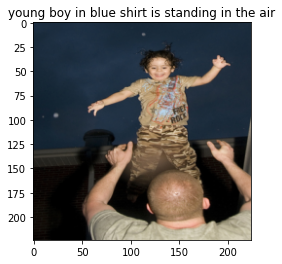

epoch: 2  batch: 10 [320/36410]  loss: 4.35735607
epoch: 2  batch: 20 [640/36410]  loss: 4.50343275
epoch: 2  batch: 30 [960/36410]  loss: 4.01382780
epoch: 2  batch: 40 [1280/36410]  loss: 4.19237471
epoch: 2  batch: 50 [1600/36410]  loss: 4.12182617
epoch: 2  batch: 60 [1920/36410]  loss: 4.14810991
epoch: 2  batch: 70 [2240/36410]  loss: 4.04460573
epoch: 2  batch: 80 [2560/36410]  loss: 4.11882210
epoch: 2  batch: 90 [2880/36410]  loss: 4.22106647
epoch: 2  batch: 100 [3200/36410]  loss: 4.39850616
epoch: 2  batch: 110 [3520/36410]  loss: 3.85962796
epoch: 2  batch: 120 [3840/36410]  loss: 4.31181908
epoch: 2  batch: 130 [4160/36410]  loss: 3.93485713
epoch: 2  batch: 140 [4480/36410]  loss: 4.12548494
epoch: 2  batch: 150 [4800/36410]  loss: 4.39180994
epoch: 2  batch: 160 [5120/36410]  loss: 4.22833157
epoch: 2  batch: 170 [5440/36410]  loss: 3.77183771
epoch: 2  batch: 180 [5760/36410]  loss: 4.03988600
epoch: 2  batch: 190 [6080/36410]  loss: 4.08999634
epoch: 2  batch: 200 [64

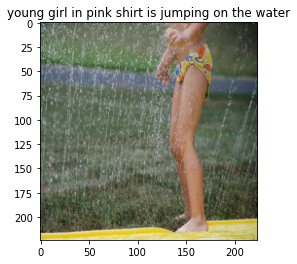

epoch: 3  batch: 10 [320/36410]  loss: 3.88734508
epoch: 3  batch: 20 [640/36410]  loss: 3.80478597
epoch: 3  batch: 30 [960/36410]  loss: 3.81366920
epoch: 3  batch: 40 [1280/36410]  loss: 3.99302983
epoch: 3  batch: 50 [1600/36410]  loss: 3.96615243
epoch: 3  batch: 60 [1920/36410]  loss: 3.67324018
epoch: 3  batch: 70 [2240/36410]  loss: 4.00652552
epoch: 3  batch: 80 [2560/36410]  loss: 3.97943377
epoch: 3  batch: 90 [2880/36410]  loss: 3.58177495
epoch: 3  batch: 100 [3200/36410]  loss: 3.80604339
epoch: 3  batch: 110 [3520/36410]  loss: 4.13938665
epoch: 3  batch: 120 [3840/36410]  loss: 3.70369029
epoch: 3  batch: 130 [4160/36410]  loss: 3.71358585
epoch: 3  batch: 140 [4480/36410]  loss: 3.89179182
epoch: 3  batch: 150 [4800/36410]  loss: 3.52002954
epoch: 3  batch: 160 [5120/36410]  loss: 3.99073672
epoch: 3  batch: 170 [5440/36410]  loss: 3.77702475
epoch: 3  batch: 180 [5760/36410]  loss: 4.04146576
epoch: 3  batch: 190 [6080/36410]  loss: 3.88395357
epoch: 3  batch: 200 [64

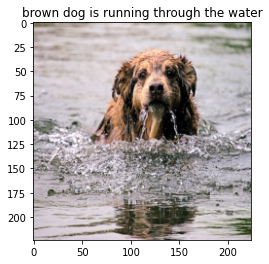

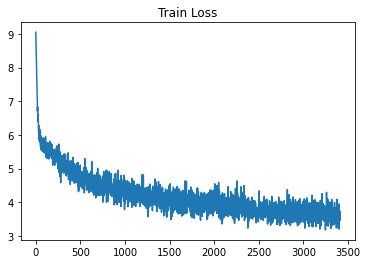

In [62]:
annotations_file = '/content/drive/MyDrive/flickr8k/captions.txt'
image_dir = '/content/drive/MyDrive/flickr8k/Images/'

transform = transforms.Compose([
    Rescale((224, 224)),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = CaptionDataset(annotations_file, image_dir, transform)

train_sampler, test_sampler = train_test_split(dataset, test_size=test_size)

train_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,
                                            sampler=train_sampler,
                                            num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset,
                                            batch_size=batch_size,
                                            sampler=test_sampler,
                                            num_workers=num_workers)

vocab_size = dataset.vocab_size

model = EncoderAttentionDecoderModel(
    embed_size=embed_size,
    vocab_size=vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.word_to_idx_mapping["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_history = []

for epoch in range(1, epochs_num + 1):

  for batch_num, data in enumerate(train_loader):
    batch_num += 1
    image, captions = data['image'], data['caption']
    image = image.type(torch.FloatTensor)
    image, captions = image.to(device), captions.to(device)
    optimizer.zero_grad()
    outputs, attentions = model(image, captions)
    targets = captions[:, 1:]
    loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
    loss.backward()
    loss_history.append(loss.item())
    optimizer.step()

    if batch_num%10 == 0:
      print(f'epoch: {epoch:1}  batch: {batch_num:1} [{batch_size*batch_num:1}/{int(len(train_sampler))}]  loss: {loss.item():10.8f}')

  model.eval()
  with torch.no_grad():
      show_image_caption_sample(train_loader, dataset, model, max_length_text)
  model.train() 

plt.plot(loss_history, label='training loss')
plt.title('Train Loss')
plt.show()


##**Evaluation**

In [105]:
model.eval()

data = next(iter(test_loader))
image = data['image']
features = model.encoder(image[0:1].to(device))
words, alphas = model.decoder.generate_caption(features, max_length_text=10, data_set=dataset)
caption = ' '.join(words)

img_sample = image[0]
img_sample[0] = img_sample[0] * 0.229 + 0.485
img_sample[1] = img_sample[1] * 0.224 + 0.456
img_sample[2] = img_sample[2] * 0.225 + 0.406
img_sample = img_sample.numpy().transpose((1, 2, 0))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


The predicted caption is: young boy in red shirt is standing on the grass



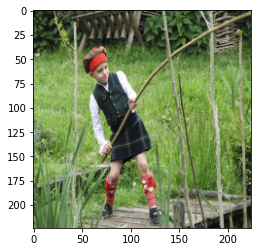

In [109]:
print(f'The predicted caption is: {caption}\n')
plt.imshow(img_sample)

The attention visualization is:



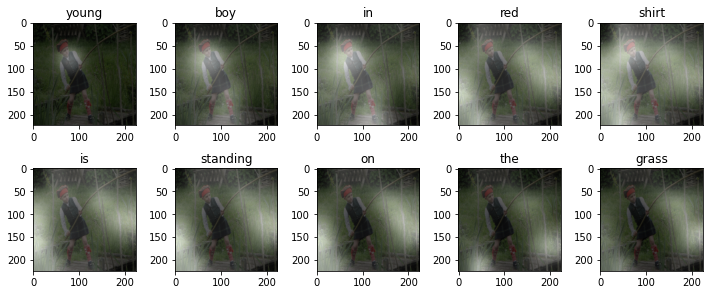

In [115]:
print(f'The attention visualization is:\n')

fig = plt.figure(figsize=(10, 10))
words_len = len(words)
for i in range(words_len):
  attenion = alphas[i]
  attenion = attenion.reshape(7,7)
  ax = fig.add_subplot(words_len//2, words_len//2, i+1)
  ax.set_title(words[i])
  img = ax.imshow(img_sample)
  ax.imshow(attenion, cmap='gray', alpha=0.75, extent=img.get_extent(), interpolation = 'bicubic')

fig.tight_layout(pad=1.0)